# Fase 3 - SVM con embeddings ItWac 32 (in-genre classification)
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo costruita attraverso l’uso dei word embedding (http://www.italianlp.it/resources/italian-word-embeddings/). Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli embedding delle singole parole e/o rispetto alle categorie grammaticali delle paroleprese in considerazione. Valutare i diversi sistemi con un processo di 5-fold cross validation condotto sul training set;
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra.

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
def load_word_embeddings(src_path):
    embeddings = dict()
    with open(src_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip().split('\t')
            word = line[0]
            embedding = line[1:]
            embedding = [float(comp) for comp in embedding]
            embeddings[word] = np.asarray(embedding)
    return embeddings

In [3]:
def load_conllu_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    tokens, pos_tags = [], []
    for line in lines:
        if line.startswith('#') or line.strip() == '':
            continue
        parts = line.strip().split('\t')
        if '-' in parts[0] or '.' in parts[0]:
            continue
        tokens.append(parts[1].lower())
        pos_tags.append(parts[3])
    return tokens, pos_tags

In [4]:
def get_label_from_filename(filename):
    return filename.split('#')[-1].split('.')[0]

In [5]:
def represent_text(tokens, model, pos_tags=None, 
                   allowed_pos=None, strategy='mean'):
    vectors = []
    for token, pos in zip(tokens, pos_tags):
        if allowed_pos and pos not in allowed_pos:
            continue
        if token in model:
            vectors.append(model[token])
    if not vectors:
        return np.zeros(next(iter(model.values())).shape[0])
    
    vectors = np.array(vectors)
    if strategy == 'mean':
        return np.mean(vectors, axis=0)
    elif strategy == 'sum':
        return np.sum(vectors, axis=0)
    elif strategy == 'max':
        return np.max(vectors, axis=0)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [6]:
dim = 32
embeddings_path = f'../../data/embeddings/itwac{dim}.txt'
embeddings = load_word_embeddings(embeddings_path)

In [10]:
strategies = [
    {'strategy': 'mean', 'allowed_pos': None, 'name': 'mean_all'},
    {'strategy': 'mean', 'allowed_pos': {'NOUN', 'ADJ'}, 'name': 'mean_noun_adj'},
    {'strategy': 'max', 'allowed_pos': {'VERB'}, 'name': 'max_verb'}
]
genres = ['children']

In [11]:
for genre in genres:
    print(f"\n=== GENRE: CHILDREN ===")
    train_folder = f"../../data/profiling_output/children/linguistic_annotation/children/"
    test_folder = f"../../data/profiling_output/children/linguistic_annotation/children/"

    for config in strategies:
        print(f"\n[STRATEGY: {config['name']}]")

        # Diagnostica: verifica file disponibili
        train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
        print(f"File trovati per il training ({len(train_files)}): {train_files[:5]}{' ...' if len(train_files) > 5 else ''}")

        X_train, y_train = [], []
        for filename in train_files:
            label = get_label_from_filename(filename)
            tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
            vector = represent_text(tokens, embeddings, pos_tags,
                                    allowed_pos=config['allowed_pos'],
                                    strategy=config['strategy'])
            X_train.append(vector)
            y_train.append(label)

        X_train = np.array(X_train)
        y_train = np.array(y_train)


        # Cross-validation
        clf = LinearSVC()
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        print("CV Accuracy:", scores)
        print("Mean CV Accuracy:", scores.mean())

        # Test set
        X_test, ids = [], []
        for filename in os.listdir(test_folder):
            if not filename.startswith('test'):
                continue
            file_id = filename.split('#')[1]
            tokens, pos_tags = load_conllu_file(os.path.join(test_folder, filename))
            vector = represent_text(tokens, embeddings, pos_tags,
                                    allowed_pos=config['allowed_pos'],
                                    strategy=config['strategy'])
            X_test.append(vector)
            ids.append(file_id)
        X_test = np.array(X_test)

        # Train final model and predict
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        
        # Save CSV in sottocartella output/predizioni
        output = pd.DataFrame({'id': ids, 'gender': predictions})
        output_dir = "output_embeddings"
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f'test_predictions_children_{config["name"]}.csv')

        output.to_csv(output_file, index=False)
        print(f"Predizioni salvate in: {output_file}")


=== GENRE: CHILDREN ===

[STRATEGY: mean_all]
File trovati per il training (200): ['training#1#children#M.conllu', 'training#10#children#M.conllu', 'training#100#children#F.conllu', 'training#101#children#F.conllu', 'training#102#children#F.conllu'] ...
CV Accuracy: [0.45  0.6   0.45  0.575 0.625]
Mean CV Accuracy: 0.54
Predizioni salvate in: output_embeddings\test_predictions_children_mean_all.csv

[STRATEGY: mean_noun_adj]
File trovati per il training (200): ['training#1#children#M.conllu', 'training#10#children#M.conllu', 'training#100#children#F.conllu', 'training#101#children#F.conllu', 'training#102#children#F.conllu'] ...
CV Accuracy: [0.6   0.625 0.725 0.55  0.55 ]
Mean CV Accuracy: 0.61
Predizioni salvate in: output_embeddings\test_predictions_children_mean_noun_adj.csv

[STRATEGY: max_verb]
File trovati per il training (200): ['training#1#children#M.conllu', 'training#10#children#M.conllu', 'training#100#children#F.conllu', 'training#101#children#F.conllu', 'training#102#chi

In [12]:
# Inizializzo tabella per i risultati
report_rows = []

for genre in genres:
    print(f"\n=== GENRE: children ===")
    train_folder = f"../../data/profiling_output/children/linguistic_annotation/children/"
    test_folder = f"../../data/profiling_output/children/linguistic_annotation/children/"

    for config in strategies:
        print(f"\n[STRATEGY: {config['name']}]")

        # Caricamento dati di training
        train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
        X_train, y_train = [], []
        for filename in train_files:
            label = get_label_from_filename(filename)
            tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
            vector = represent_text(tokens, embeddings, pos_tags,
                                    allowed_pos=config['allowed_pos'],
                                    strategy=config['strategy'])
            X_train.append(vector)
            y_train.append(label)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        clf = LinearSVC()
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

        print("CV Accuracy:", scores)
        print("Mean CV Accuracy:", scores.mean())

        # Aggiunta al report
        report_rows.append({
            "genre": genre,
            "strategy": config["name"],
            "fold1": scores[0],
            "fold2": scores[1],
            "fold3": scores[2],
            "fold4": scores[3],
            "fold5": scores[4],
            "mean_accuracy": scores.mean()
        })


=== GENRE: children ===

[STRATEGY: mean_all]
CV Accuracy: [0.45  0.6   0.45  0.575 0.625]
Mean CV Accuracy: 0.54

[STRATEGY: mean_noun_adj]
CV Accuracy: [0.6   0.625 0.725 0.55  0.55 ]
Mean CV Accuracy: 0.61

[STRATEGY: max_verb]
CV Accuracy: [0.325 0.6   0.575 0.625 0.55 ]
Mean CV Accuracy: 0.5349999999999999


In [13]:
# Salvataggio CSV del report
output_dir = "output_embeddings"
os.makedirs(output_dir, exist_ok=True)

report_df = pd.DataFrame(report_rows)
report_path = os.path.join(output_dir, "report_valutazione.csv")
report_df.to_csv(report_path, index=False)
print(f"\nReport salvato in {report_path}")


Report salvato in output_embeddings\report_valutazione.csv


In [17]:
# REPORT FINALE SUL TEST SET (usando file gold)
test_results = []

# Mappa abbreviazioni genere -> nome completo
genre_map = {
    "CH": "children",
    "DI": "diary",
    "JO": "journalism",
    "TW": "twitter"
}

# Mappa inversa: nome completo -> abbreviazione
inverse_map = {v: k for k, v in genre_map.items()}

for filename in os.listdir("output_embeddings"):
    if not filename.startswith("test_predictions_"):
        continue

    # Estrai genere e strategia dal nome file
    parts = filename.replace("test_predictions_", "").replace(".csv", "").split("_")
    genre = parts[0]
    strategy = "_".join(parts[1:])
    genre_abbr = inverse_map[genre]

    # Predizioni
    pred_df = pd.read_csv(os.path.join("output_embeddings", filename))

    # Etichette gold
    gold_path = f"../../data/dataset_originale/gold/test_{genre_abbr}.gold"
    gold_df = pd.read_csv(gold_path, sep="\t", header=None, names=["id", "gender"])
    gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

    # Allinea predizioni e gold
    pred_ids = pred_df["id"].astype(str)
    pred_labels = pred_df["gender"]
    gold_labels = [gold_dict.get(i, "UNK") for i in pred_ids]

    # Filtra quelli con etichetta nota
    filtered = [(p, g) for p, g in zip(pred_labels, gold_labels) if g in {"M", "F"}]
    if not filtered:
        acc = 0.0
    else:
        y_pred, y_true = zip(*filtered)
        acc = accuracy_score(y_true, y_pred)

    test_results.append({
        "genre": genre,
        "strategy": strategy,
        "test_accuracy": acc
    })

In [18]:
# Salvataggio CSV del report
df_test = pd.DataFrame(test_results)
df_test.to_csv("output_embeddings/risultati_test_set.csv", index=False)
print("Report test salvato in: output_embeddings/risultati_test_set.csv")

Report test salvato in: output_embeddings/risultati_test_set.csv



Confusion Matrix - Genere: children | Strategia: max_verb


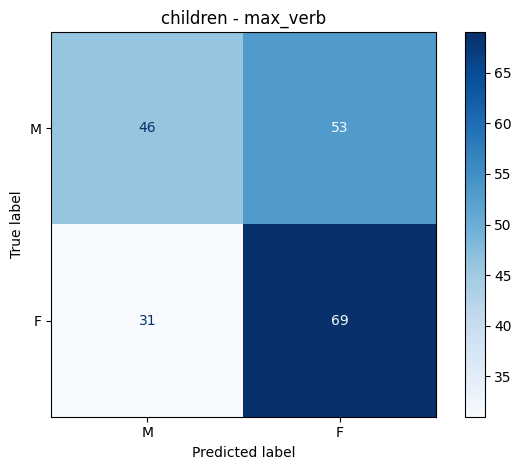


Confusion Matrix - Genere: children | Strategia: mean_all


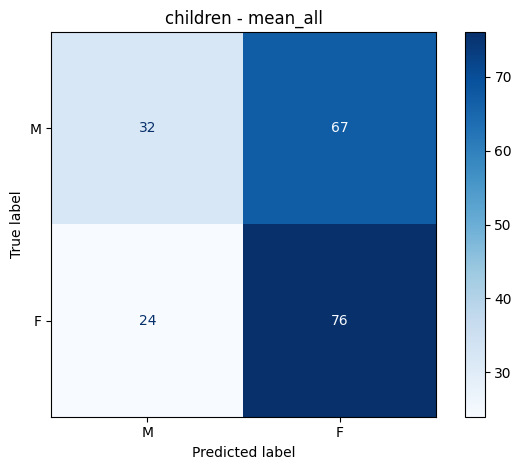


Confusion Matrix - Genere: children | Strategia: mean_noun_adj


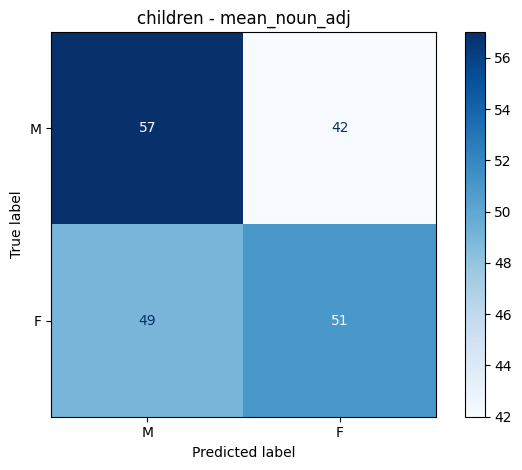

In [22]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === CONFUSION MATRIX PER IL TEST SET (solo matplotlib) ===

genre_map = {
    "CH": "children",
    "DI": "diary",
    "JO": "journalism",
    "TW": "twitter"
}

inverse_map = {v: k for k, v in genre_map.items()}

for filename in os.listdir("output_embeddings"):
    if not filename.startswith("test_predictions_"):
        continue

    parts = filename.replace("test_predictions_", "").replace(".csv", "").split("_")
    genre = parts[0]
    strategy = "_".join(parts[1:])
    genre_abbr = inverse_map[genre]

    pred_df = pd.read_csv(os.path.join("output_embeddings", filename))

    gold_path = f"../../data/dataset_originale/gold/test_{genre_abbr}.gold"
    gold_df = pd.read_csv(gold_path, sep="\t", header=None, names=["id", "gender"])
    gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

    pred_ids = pred_df["id"].astype(str)
    pred_labels = pred_df["gender"]
    gold_labels = [gold_dict.get(i, "UNK") for i in pred_ids]

    filtered = [(p, g) for p, g in zip(pred_labels, gold_labels) if g in {"M", "F"}]
    if not filtered:
        print(f"[children - {strategy}] Nessuna etichetta valida trovata.")
        continue

    y_pred, y_true = zip(*filtered)
    cm = confusion_matrix(y_true, y_pred, labels=["M", "F"])

    print(f"\nConfusion Matrix - Genere: children | Strategia: {strategy}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
    disp.plot(cmap="Blues")
    plt.title(f"children - {strategy}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [27]:
from sklearn.dummy import DummyClassifier

# === VALUTAZIONE BASELINE CON DUMMY CLASSIFIER ===
dummy_results = []

for genre in genres:
    print(f"\n=== DUMMY CLASSIFIER - GENRE: {genre} ===")
    train_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/{genre}/"
    test_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/{genre}/"

    train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
    X_train, y_train = [], []
    for filename in train_files:
        label = get_label_from_filename(filename)
        tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
        vector = represent_text(tokens, embeddings, pos_tags, strategy='mean')  # usa 'mean' come default
        X_train.append(vector)
        y_train.append(label)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)

    # Test set
    X_test, ids = [], []
    for filename in os.listdir(test_folder):
        if not filename.startswith("test"):
            continue
        file_id = filename.split('#')[1]
        tokens, pos_tags = load_conllu_file(os.path.join(test_folder, filename))
        vector = represent_text(tokens, embeddings, pos_tags, strategy='mean')
        X_test.append(vector)
        ids.append(file_id)

    X_test = np.array(X_test)
    predictions = dummy.predict(X_test)

    # Etichette gold
    genre_abbr = {"children": "CH", "diary": "DI", "journalism": "JO", "twitter": "TW"}[genre]
    gold_df = pd.read_csv(f"../../data/dataset_originale/gold/test_{genre_abbr}.gold", sep="\t", header=None, names=["id", "gender"])
    gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

    gold_labels = [gold_dict.get(str(i), "UNK") for i in ids]
    filtered = [(p, g) for p, g in zip(predictions, gold_labels) if g in {"M", "F"}]

    if filtered:
        y_pred, y_true = zip(*filtered)
        acc = accuracy_score(y_true, y_pred)
    else:
        acc = 0.0

    dummy_results.append({
        "genre": genre,
        "strategy": "dummy_most_frequent",
        "test_accuracy": acc
    })

# Salva il report dummy
df_dummy = pd.DataFrame(dummy_results)
df_dummy.to_csv("output_embeddings/risultati_test_set_dummy.csv", index=False)
print("Dummy classifier: report salvato in output_embeddings/risultati_test_set_dummy.csv")


=== DUMMY CLASSIFIER - GENRE: children ===
Dummy classifier: report salvato in output_embeddings/risultati_test_set_dummy.csv
